In [2]:
%matplotlib inline
import numpy as np


>作者: Pauli Virtanen   
>原文: http://www.scipy-lectures.org/advanced/advanced_numpy/index.html   


Numpy是Python科学工具栈的基础。它的目的很简单：在一个内存块上实现针对多个条目（items）的高效操作。了解它的工作细节有助于有效的使用它的灵活性，使用有用的快捷方式，基于它构建新的工作。

这个指南的目的包括：
- 剖析Numpy数组，以及它的重要性。提示与技巧。
- 通用函数：是什么、为什么以及如果你需要一个全新的该做什么。
- 与其他工具整合：Numpy提供了一些方式将任意数据封装为ndarray，而不需要不必要的复制。
- 新近增加的功能，对我来说他们包含什么：PEP 3118 buffers、广义ufuncs, ...


---
**先决条件**
- Numpy (>= 1.2; 越新越好...)
- Cython (>= 0.12, 对于Ufunc例子)
- Pillow (Python 处理图形的库，在一些例子中使用)

---

在这个部分，numpy将被如下引入：

In [3]:
import numpy as np

章节内容
- ndarry的一生
    - 它是...
    - 内存块
    - 数据类型
    - 索引体系：strides
    - 剖析中的发现
- 通用函数
    - 他们是什么？
    - 练习：从零开始构建一个ufunc
    - 答案：从零开始构建一个ufunc
    - 广义ufuncs
- 协同工作功能
    - 共享多维度，类型数据
    - 旧的buffer协议
    - 旧的buffer协议
    - 数组接口协议
- 数组切片：`chararray`、`maskedarray`、`matrix`
    - `chararray`：向量化字符操作
    - `masked_array` 缺失值
    - recarray：纯便利
    - `matrix`：便利？
- 总结
- 为Numpy/Scipy做贡献
    - 为什么
    - 报告bugs
    - 贡献文档
    - 贡献功能
    - 如何帮忙，总的来说

## 2.2.1 ndarray的一生

### 2.2.1.1 它是...

**ndarray** =

    内存块 + 索引体系 + 数据类型描述符
    
- 原始数据
- 如何定位(locate)一个元素
- 如何解释(interpret)一个元素
![ndarray](http://www.scipy-lectures.org/_images/threefundamental.png)

```C
typedef struct PyArrayObject {
        PyObject_HEAD

        /* 内存块  */
        char *data;

        /* 数据类型描述符 */
        PyArray_Descr *descr;

        /* 索引体系 */
        int nd;
        npy_intp *dimensions;
        npy_intp *strides;

        /* 其他属性 */
        PyObject *base;
        int flags;
        PyObject *weakreflist;
} PyArrayObject;
```

### 2.2.1.2 内存块

In [4]:
x = np.array([1, 2, 3, 4], dtype=np.int32)
x.data

In [5]:
str(x.data)

'<memory at 0x10f1ed408>'

数据的内存地址：

In [6]:
x.__array_interface__['data'][0] 

140264211656336

完整的`__array_interface__`：

In [7]:
x.__array_interface__

{'data': (140264211656336, False),
 'descr': [('', '<i4')],
 'shape': (4,),
 'strides': None,
 'typestr': '<i4',
 'version': 3}

提醒：两个`ndarrays`可以共享相同的内存：

In [8]:
x = np.array([1, 2, 3, 4])
y = x[:-1]
x[0] = 9
y

array([9, 2, 3])

内存不必为一个`ndarray`拥有：

In [11]:
x = b'1234' # 'b' 指代 "bytes", Python 3中要这么使用
y = np.frombuffer(x, dtype=np.int8)
y.data  

In [12]:
y.base is x

True

In [13]:
y.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : False
  ALIGNED : True
  UPDATEIFCOPY : False

`owndata`和`writeable`标记表明了内存块的状态。

### 2.2.1.3 数据类型
#### 2.2.1.3.1 描述符
`dtype`描述了数组里的一个项目：

|   |   |
|---|---|
|type|数据的**标量类型**，int8、int16、float64等之一（固定大小），str、unicode、void（可变大小）|
|itemsize|数据块的**大小**|
|byteorder|**字节序**: big-endian `>` / little-endian `<` / 不可用 |
|fields|子-dtypes，如果是一个**结构化的数据类型**|
|shape|数组的形状，如果是一个**子数组**|

In [14]:
np.dtype(int).type

numpy.int64

In [15]:
np.dtype(int).itemsize

8

In [16]:
np.dtype(int).byteorder

'='

#### 2.2.1.3.2 例子：读取.wav文件

The`.wav` file header:

|   |   |
|---|---|
|chunk_id|"RIFF"|
|chunk_size|4字节无符号little-endian整型|
|format|"WAVE"|
|fmt_id|"fmt "|
|fmt_size|4字节无符号little-endian整型|
|audio_fmt|2字节无符号little-endian整型|
|num_channels|2字节无符号little-endian整型|
|sample_rate|4字节无符号little-endian整型|
|byte_rate|4字节无符号little-endian整型|
|block_align|2字节无符号little-endian整型|
|bits_per_sample|2字节无符号little-endian整型|
|data_id|"data"|
|data_size|4字节无符号little-endian整型|

- 44字节块的原始数据（在文件的开头）
- ...接下来是`data_size` 实际声音数据的字节。

`.wav`文件头是Numpy结构化数据类型：

In [17]:
wav_header_dtype = np.dtype([
    ("chunk_id", (str, 4)),   # flexible-sized scalar type, item size 4
    ("chunk_size", "<u4"),    # little-endian unsigned 32-bit integer
    ("format", "S4"),         # 4-byte string
    ("fmt_id", "S4"),
    ("fmt_size", "<u4"),
    ("audio_fmt", "<u2"),     #
    ("num_channels", "<u2"),  # .. more of the same ...
    ("sample_rate", "<u4"),   #
    ("byte_rate", "<u4"),
    ("block_align", "<u2"),
    ("bits_per_sample", "<u2"),
    ("data_id", ("S1", (2, 2))), # sub-array, just for fun!
    ("data_size", "u4"),
    #
    # the sound data itself cannot be represented here:
    # it does not have a fixed size
   ])

也可以看一下`wavreader.py`

In [18]:
wav_header_dtype['format']

dtype('S4')

In [19]:
wav_header_dtype.fields     

mappingproxy({'audio_fmt': (dtype('uint16'), 32),
              'bits_per_sample': (dtype('uint16'), 46),
              'block_align': (dtype('uint16'), 44),
              'byte_rate': (dtype('uint32'), 40),
              'chunk_id': (dtype('<U4'), 0),
              'chunk_size': (dtype('uint32'), 16),
              'data_id': (dtype(('S1', (2, 2))), 48),
              'data_size': (dtype('uint32'), 52),
              'fmt_id': (dtype('S4'), 24),
              'fmt_size': (dtype('uint32'), 28),
              'format': (dtype('S4'), 20),
              'num_channels': (dtype('uint16'), 34),
              'sample_rate': (dtype('uint32'), 36)})

In [20]:
wav_header_dtype.fields['format']

(dtype('S4'), 20)

- 第一个元素是结构化数据中对应于名称`format`的子类型
- 第二个是它的从项目开始的偏移（以字节计算）


**练习**

小练习，通过使用偏移来创造一个“稀释”的dtype，只使用一些字段：


In [ ]:
wav_header_dtype = np.dtype(dict(
  names=['format', 'sample_rate', 'data_id'],
  offsets=[offset_1, offset_2, offset_3], # counted from start of structure in bytes
  #formats=list of dtypes for each of the fields,
)) 

并且用它来读取sample rate和`data_id`（就像子数组）。

In [7]:
f = open('data/test.wav', 'r')
wav_header = np.fromfile(f, dtype=wav_header_dtype, count=1)
f.close()
print(wav_header)

[ ('RIFF', 17402L, 'WAVE', 'fmt ', 16L, 1, 1, 16000L, 32000L, 2, 16, [['d', 'a'], ['t', 'a']], 17366L)]


In [8]:
wav_header['sample_rate']

array([16000], dtype=uint32)

让我们访问子数组：

In [9]:
wav_header['data_id']

array([[['d', 'a'],
        ['t', 'a']]], 
      dtype='|S1')

In [10]:
wav_header.shape

(1,)

In [11]:
wav_header['data_id'].shape

(1, 2, 2)

当访问子数组时，维度被添加到末尾！

---

**注意：**有许多模块可以用于加载声音数据，比如`wavfile`、`audiolab`等...

---

#### 2.2.1.3.3 投射和再解释/视图

**投射**
- 赋值
- 数组构建
- 算术
- 等等
- 手动：`.astype(dtype)`

**data re-interpretation**
- 手动：`.view(dtype)`

##### 2.2.1.3.3.1 投射

- 算术投射，简而言之：
    - 只有类型（不是值！）操作符最重要
    - 最大的“安全”模式能代表选出的两者
    - 在一些情况下，数组中的量值可能“丢失”
- 在通用复制数据中的投射：

In [24]:
x = np.array([1, 2, 3, 4], dtype=np.float)
x

array([ 1.,  2.,  3.,  4.])

In [25]:
y = x.astype(np.int8)
y

array([1, 2, 3, 4], dtype=int8)

In [26]:
y + 1

array([2, 3, 4, 5], dtype=int8)

In [7]:
y + 256

array([257, 258, 259, 260], dtype=int16)

In [8]:
y + 256.0

array([ 257.,  258.,  259.,  260.])

In [9]:
y + np.array([256], dtype=np.int32)

array([257, 258, 259, 260], dtype=int32)

- 集合项目上的投射：数组的dtype在项目赋值过程中不会改变：

In [10]:
y[:] = y + 1.5
y

array([2, 3, 4, 5], dtype=int8)

---

**注意** 具体规则：见文档：http://docs.scipy.org/doc/numpy/reference/ufuncs.html#casting-rules

---

##### 2.2.1.3.3.2 再解释/视图

- 内存中的数据块（4字节）

0x01	||	0x02	||	0x03	||	0x04
    - 4 of uint8, OR,
    - 4 of int8, OR,
    - 2 of int16, OR,
    - 1 of int32, OR,
    - 1 of float32, OR,
    - ...

如何从一个切换另一个？
- 切换dtype：

In [27]:
x = np.array([1, 2, 3, 4], dtype=np.uint8)
x.dtype = "<i2"
x

array([ 513, 1027], dtype=int16)

In [28]:
0x0201, 0x0403

(513, 1027)

0x01	0x02	||	0x03	0x04

---

**注意** little-endian：越不重要的字节在内存的左侧

---

- 创建新视图：

In [29]:
y = x.view("<i4")
y

array([67305985], dtype=int32)

In [30]:
0x04030201

67305985

0x01	0x02	0x03	0x04

---

**注意：**
- **`.view()`创建视图，并不复制（或改变）内存块**
- **只改变dtype（调整数组形状）:**

In [31]:
x[1] = 5

In [32]:
y

array([328193], dtype=int32)

In [33]:
y.base is x

True

---

**小练习：数据再解释**

**也可以看一下：** `view-colors.py`

数组中的RGBA数据：

In [19]:
x = np.zeros((10, 10, 4), dtype=np.int8)
x[:, :, 0] = 1
x[:, :, 1] = 2
x[:, :, 2] = 3
x[:, :, 3] = 4

后三个维度是R、B和G，以及alpha通道。

如何用字段名‘r’, ‘g’, ‘b’, ‘a’创建一个（10，10）结构化数组而不用复制数据？

In [ ]:
y = x.view([('r', 'i1'),
            ('g', 'i1'),
            ('b', 'i1'),
            ('a', 'i1')]
          )[:, :, 0]

assert (y['r'] == 1).all()  
assert (y['g'] == 2).all()  
assert (y['b'] == 3).all()  
assert (y['a'] == 4).all()

---

**警告：**另一个占有四个字节内存的数组：

In [36]:
y = np.array([[1, 3], [2, 4]], dtype=np.uint8).transpose()
x = y.copy()
x

array([[1, 2],
       [3, 4]], dtype=uint8)

In [37]:
y

array([[1, 2],
       [3, 4]], dtype=uint8)

In [38]:
x.view(np.int16)

array([[ 513],
       [1027]], dtype=int16)

In [39]:
0x0201, 0x0403

(513, 1027)

In [40]:
y.view(np.int16)

/Users/linyong/anaconda/envs/pydata/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  """Entry point for launching an IPython kernel.


array([[ 769, 1026]], dtype=int16)

- 发生了什么？
- ... 我们需要实际看一下x[0,1]里面是什么

In [41]:
0x0301, 0x0402

(769, 1026)

---

### 2.2.1.4 索引体系：步幅
#### 2.2.1.4.1 主要观点

**问题**

In [42]:
x = np.array([[1, 2, 3],
             [4, 5, 6],
             [7, 8, 9]], dtype=np.int8)
str(x.data)

'<memory at 0x10f061ea0>'

item x[1,2]开始在`x.data`中的哪个字节？

**答案**（在Numpy）
- **步幅**：寻找一下个元素跳跃的字节数
- 每个维度一个步幅

In [43]:
x.strides

(3, 1)

In [44]:
byte_offset = 3*1 + 1*2   # 查找x[1,2]
x.flat[byte_offset]

6

In [45]:
x[1, 2]

6

- 简单、**灵活**

##### 2.2.1.4.1.1 C 和 Fortran 顺序

In [46]:
x = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]], dtype=np.int16, order='C')
x.strides

(6, 2)

In [48]:
str(x.data)

- 需要跳跃6个字节寻找下一行
- 需要跳跃2个字节寻找下一列

In [49]:
y = np.array(x, order='F')
y.strides

(2, 6)

In [50]:
str(y.data)

'<memory at 0x10f061ea0>'

- 需要跳跃2个字节寻找下一行
- 需要跳跃6个字节寻找下一列

更高维度也类似：
    - C：最后的维度变化最快（=最小的步幅）
    - F：最早的维度变化最快
    
![png](http://www.scipy-lectures.org/_images/math/f9d27734438964d22cb2d6449ef13c33c2b76f82.png)

---

**注意**：现在我们可以理解`.view()`的行为：


In [51]:
y = np.array([[1, 3], [2, 4]], dtype=np.uint8).transpose()
x = y.copy()

变换顺序不影响数据的内部布局，只是步幅

In [52]:
x.strides

(2, 1)

In [53]:
y.strides

(1, 2)

In [54]:
str(x.data)

'<memory at 0x10f061ea0>'

In [55]:
str(y.data)

'<memory at 0x10f061ea0>'

- 当解释为int16时结果会不同
- `.copy()`以C顺序（默认）创建新的数组

---

##### 2.2.1.4.1.2 用整数切片

- 通过仅改变形状、步幅和可能调整数据指针可以代表任何东西！
- 不用制造数据的副本

In [56]:
x = np.array([1, 2, 3, 4, 5, 6], dtype=np.int32)
y = x[::-1]
y

array([6, 5, 4, 3, 2, 1], dtype=int32)

In [57]:
y.strides

(-4,)

In [58]:
y = x[2:]
y.__array_interface__['data'][0] - x.__array_interface__['data'][0]

8

In [59]:
x = np.zeros((10, 10, 10), dtype=np.float)
x.strides

(800, 80, 8)

In [60]:
x[::2,::3,::4].strides

(1600, 240, 32)

- 类似的，变换顺序绝不会创建副本（只是交换的步幅）

In [61]:
x = np.zeros((10, 10, 10), dtype=np.float)
x.strides

(800, 80, 8)

In [62]:
x.T.strides

(8, 80, 800)

但是：并不是所有的重排操作都可以通过操纵步幅来完成。

In [63]:
a = np.arange(6, dtype=np.int8).reshape(3, 2)
b = a.T
b.strides

(1, 2)

到目前为止，都很不错，但是：

In [64]:
str(a.data)

'<memory at 0x10f061ea0>'

In [65]:
b

array([[0, 2, 4],
       [1, 3, 5]], dtype=int8)

In [66]:
c = b.reshape(3*2)
c

array([0, 2, 4, 1, 3, 5], dtype=int8)

这里，没办法用一个给定的步长和`a`的内存块来表示数组`c`。因此，重排操作在这里需要制作一个副本。

#### 2.2.1.4.2 例子：用步长伪造维度

**步长操作**

In [67]:
from numpy.lib.stride_tricks import as_strided
help(as_strided)    

Help on function as_strided in module numpy.lib.stride_tricks:

as_strided(x, shape=None, strides=None, subok=False, writeable=True)
    Create a view into the array with the given shape and strides.
    
    .. warning:: This function has to be used with extreme care, see notes.
    
    Parameters
    ----------
    x : ndarray
        Array to create a new.
    shape : sequence of int, optional
        The shape of the new array. Defaults to ``x.shape``.
    strides : sequence of int, optional
        The strides of the new array. Defaults to ``x.strides``.
    subok : bool, optional
        .. versionadded:: 1.10
    
        If True, subclasses are preserved.
    writeable : bool, optional
        .. versionadded:: 1.12
    
        If set to False, the returned array will always be readonly.
        Otherwise it will be writable if the original array was. It
        is advisable to set this to False if possible (see Notes).
    
    Returns
    -------
    view : ndarray
    
   

---

**警告**：`as_strided`并不检查你是否还待在内存块边界里..

---

In [68]:
x = np.array([1, 2, 3, 4], dtype=np.int16)
as_strided(x, strides=(2*2, ), shape=(2, ))

array([1, 3], dtype=int16)

In [69]:
x[::2]

array([1, 3], dtype=int16)

**练习**

In [ ]:
array([1, 2, 3, 4], dtype=np.int8)

-> array([[1, 2, 3, 4],
          [1, 2, 3, 4],
          [1, 2, 3, 4]], dtype=np.int8)

仅使用`as_strided`.:

提示：`byte_offset = stride[0]\*index[0] + stride[1]\*index[1] + ...`

解密：

步长可以设置为0：

In [70]:
x = np.array([1, 2, 3, 4], dtype=np.int8)
y = as_strided(x, strides=(0, 1), shape=(3, 4))
y

array([[1, 2, 3, 4],
       [1, 2, 3, 4],
       [1, 2, 3, 4]], dtype=int8)

In [71]:
y.base.base is x

True

#### 2.2.1.4.3 广播
- 用它来做一些有用的事情：[1, 2, 3, 4]和[5, 6, 7]的外积

In [72]:
x = np.array([1, 2, 3, 4], dtype=np.int16)
x2 = as_strided(x, strides=(0, 1*2), shape=(3, 4))
x2

array([[1, 2, 3, 4],
       [1, 2, 3, 4],
       [1, 2, 3, 4]], dtype=int16)

In [74]:
y = np.array([5, 6, 7], dtype=np.int16)
y2 = as_strided(y, strides=(1*2, 0), shape=(3, 4))
y2

array([[5, 5, 5, 5],
       [6, 6, 6, 6],
       [7, 7, 7, 7]], dtype=int16)

In [75]:
x2 * y2

array([[ 5, 10, 15, 20],
       [ 6, 12, 18, 24],
       [ 7, 14, 21, 28]], dtype=int16)

**...看起来有一些熟悉...**

In [76]:
x = np.array([1, 2, 3, 4], dtype=np.int16)
y = np.array([5, 6, 7], dtype=np.int16)
x[np.newaxis,:] * y[:,np.newaxis]

array([[ 5, 10, 15, 20],
       [ 6, 12, 18, 24],
       [ 7, 14, 21, 28]], dtype=int16)

* 在内部，数组**广播**的确使用0步长来实现的。

#### 2.2.1.4.4 更多技巧：对角线

**挑战**

- 提取矩阵对角线的起点：（假定是C内存顺序）：

```python
x = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]], dtype=np.int32)

x_diag = as_strided(x, shape=(3,), strides=(???,)) 
```

- 提取第一个超级-对角线的起点[2,6]。
- 那么子对角线呢？

（后两个问题的提示：切片首先移动步长起点的点。）

答案

提取对角线：

In [77]:
x_diag = as_strided(x, shape=(3, ), strides=((3+1)*x.itemsize, ))
x_diag

array([     1, -29117,      2], dtype=int16)

首先切片，调整数据指针：

In [ ]:
as_strided(x[0, 1:], shape=(2, ), strides=((3+1)*x.itemsize, ))

In [ ]:
as_strided(x[1:, 0], shape=(2, ), strides=((3+1)*x.itemsize, ))

**备注： 使用 np.diag**

In [80]:
y = np.diag(x, k=1)
y

array([[0, 1, 0, 0, 0],
       [0, 0, 2, 0, 0],
       [0, 0, 0, 3, 0],
       [0, 0, 0, 0, 4],
       [0, 0, 0, 0, 0]], dtype=int16)

但是

In [81]:
y.flags.owndata

True

*** 注意 ***：Numpy 1.9之前，`np.diag` 会做一个拷贝。

**挑战**

计算张量的迹：

In [83]:
x = np.arange(5*5*5*5).reshape(5,5,5,5)
s = 0
for i in range(5):
   for j in range(5):
      s += x[j,i,j,i]

通过跨越并且在结果上使用`sum()`。

```python
y = as_strided(x, shape=(5, 5), strides=(TODO, TODO))   
s2 = ...   
assert s == s2
```

答案

In [84]:
y = as_strided(x, shape=(5, 5), strides=((5*5*5 + 5)*x.itemsize,
                                         (5*5 + 1)*x.itemsize))
s2 = y.sum()

#### 2.2.1.4.5 CPU缓存效果

内存布局可以影响性能：

In [85]:
x = np.zeros((20000,))
y = np.zeros((20000*67,))[::67]
x.shape, y.shape

((20000,), (20000,))

In [88]:
%timeit x.sum()

10 µs ± 20.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [89]:
%timeit y.sum()

37.2 µs ± 1.08 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [16]:
x.strides, y.strides

((8,), (536,))

**小步长更快？**

![](http://www.scipy-lectures.org/_images/cpu-cacheline.png)

- CPU从主内存中拉取数据到缓存块(pulls data from main memory to its cache in blocks)
- 如果需要数据项连续操作适应于一个内存块（小步长）：
    - 需要更少的迁移
    - 更快
    
**也可以看一下**：[numexpr](https://github.com/pydata/numexpr)设计用来减轻数组计算时的缓存效果。

#### 2.2.1.4.6 例子：原地操作（买者当心）

有时，

`a -= b`

并不等同于

`a -= b.copy() `

In [90]:
x = np.array([[1, 2], [3, 4]])
x -= x.transpose()
x

array([[ 0, -1],
       [ 1,  0]])

In [91]:
y = np.array([[1, 2], [3, 4]])
y -= y.T.copy()
y

array([[ 0, -1],
       [ 1,  0]])

- `x`和`x.transpose()`共享数据
- `x -= x.transpose()`逐个元素修改数据...
- 因为`x`和`x.transpose()`步长不同，修改后的数据重新出现在RHS

### 2.2.1.5 剖析上的发现

![](http://www.scipy-lectures.org/_images/threefundamental.png)

- *内存块*：可以共享，`.base`、`.data`
- *数据类型描述符*：结构化数据、子数组、字节顺序、投射、视图、`.astype()`、`.view()`
- *步长索引*：跨越、C/F-order、w/ 整数切片、`as_strided`、广播、跨越技巧、`diag`、CPU缓存一致性

## 2.2.2 通用函数

### 2.2.2.1 他们是什么？

- Ufunc在数组的所有元素上进行元素级操作。

例子：

`np.add`、`np.subtract`、`scipy.special`.*, ...

- 自动话支持：广播、投射...
- ufunc的作者只提供了元素级操作，Numpy负责剩下的。
- 元素级操作需要在C中实现（或者比如Cython）

#### 2.2.2.1.1 Ufunc的部分

- 由用户提供

```C
void ufunc_loop(void **args, int *dimensions, int *steps, void *data)
{
    /*
     * int8 output = elementwise_function(int8 input_1, int8 input_2)
     *
     * This function must compute the ufunc for many values at once,
     * in the way shown below.
     */
    char *input_1 = (char*)args[0];
    char *input_2 = (char*)args[1];
    char *output = (char*)args[2];
    int i;

    for (i = 0; i < dimensions[0]; ++i) {
        *output = elementwise_function(*input_1, *input_2);
        input_1 += steps[0];
        input_2 += steps[1];
        output += steps[2];
    }
}
```

- Numpy部分，由下面的代码创建

```C
char types[3]

types[0] = NPY_BYTE   /* type of first input arg */
types[1] = NPY_BYTE   /* type of second input arg */
types[2] = NPY_BYTE   /* type of third input arg */

PyObject *python_ufunc = PyUFunc_FromFuncAndData(
    ufunc_loop,
    NULL,
    types,
    1, /* ntypes */
    2, /* num_inputs */
    1, /* num_outputs */
    identity_element,
    name,
    docstring,
    unused)
```

    - ufunc也可以支持多种不同输入输出类型组合。

#### 2.2.2.1.2 简化一下

`ufunc_loop`是非常通用的模式，Numpy提供了预制

|   |   |
|---|---|
|`PyUfunc_f_f`|`float elementwise_func(float input_1)`|
|`PyUfunc_ff_f`|`float elementwise_func(float input_1, float input_2)`|
|`PyUfunc_d_d`|`double elementwise_func(double input_1)`|
|`PyUfunc_dd_d`|`double elementwise_func(double input_1, double input_2)`|
|`PyUfunc_D_D`|`elementwise_func(npy_cdouble \*input, npy_cdouble\* output)`|
|`PyUfunc_DD_D`|`elementwise_func(npy_cdouble \*in1, npy_cdouble \*in2, npy_cdouble\* out)`|

    - 只有需要提供`elementwise_func`
    - ... 除非当你的元素级函数不是上面的形式中的任何一种

    
### 2.2.2.2 练习：从0开始构建一个ufunc

Mandelbrot分形由如下迭代定义：

![](http://www.scipy-lectures.org/_images/math/a8ced34b782ab71770c847a2aaa149b2dd41c7bc.png)

$C=X+iy$ 是一个复数，只要$Z$仍然是有限的，无论迭代要跑多久，迭代都会重复。$C$属于Mandelbrot集。

- ufunc调用`mandel(z0, c)`计算：

```python
z = z0
for k in range(iterations):
    z = z*z + c
```

比如，一百次迭代或者直到`z.real**2 + z.imag**2 > 1000`。用它来决定哪个`C`是在Mandelbrot集中。

- 我们的函数是很简单的，因此，请利用`PyUFunc_*`助手。
- 用Cython来完成


提醒：一些预设Ufunc循环：

|   |   |
|---|---|
|`PyUfunc_f_f`|`float elementwise_func(float input_1)`|
|`PyUfunc_ff_f`|	`float elementwise_func(float input_1, float input_2)`|
|`PyUfunc_d_d`|	`double elementwise_func(double input_1)`|
|`PyUfunc_dd_d`|	`double elementwise_func(double input_1, double input_2)`|
|`PyUfunc_D_D`|	`elementwise_func(complex_double *input, complex_double* output)`|
|`PyUfunc_DD_D`|	`elementwise_func(complex_double *in1, complex_double *in2, complex_double* out)`|

类型代码：

---

NPY_BOOL, NPY_BYTE, NPY_UBYTE, NPY_SHORT, NPY_USHORT, NPY_INT, NPY_UINT,
NPY_LONG, NPY_ULONG, NPY_LONGLONG, NPY_ULONGLONG, NPY_FLOAT, NPY_DOUBLE,
NPY_LONGDOUBLE, NPY_CFLOAT, NPY_CDOUBLE, NPY_CLONGDOUBLE, NPY_DATETIME,
NPY_TIMEDELTA, NPY_OBJECT, NPY_STRING, NPY_UNICODE, NPY_VOID

---

#### 2.2.2.3 答案：从0开始创建一个ufunc

```python
# The elementwise function
# ------------------------

cdef void mandel_single_point(double complex *z_in, 
                              double complex *c_in,
                              double complex *z_out) nogil:
    #
    # The Mandelbrot iteration
    #

    #
    # Some points of note:
    #
    # - It's *NOT* allowed to call any Python functions here.
    #
    #   The Ufunc loop runs with the Python Global Interpreter Lock released.
    #   Hence, the ``nogil``.
    #
    # - And so all local variables must be declared with ``cdef``
    #
    # - Note also that this function receives *pointers* to the data;
    #   the "traditional" solution to passing complex variables around
    #

    cdef double complex z = z_in[0]
    cdef double complex c = c_in[0]
    cdef int k  # the integer we use in the for loop

    # Straightforward iteration

    for k in range(100):
        z = z*z + c
        if z.real**2 + z.imag**2 > 1000:
            break

    # Return the answer for this point
    z_out[0] = z


# Boilerplate Cython definitions
#
# You don't really need to read this part, it just pulls in
# stuff from the Numpy C headers.
# ----------------------------------------------------------

cdef extern from "numpy/arrayobject.h":
    void import_array()
    ctypedef int npy_intp
    cdef enum NPY_TYPES:
        NPY_CDOUBLE

cdef extern from "numpy/ufuncobject.h":
    void import_ufunc()
    ctypedef void (*PyUFuncGenericFunction)(char**, npy_intp*, npy_intp*, void*)
    object PyUFunc_FromFuncAndData(PyUFuncGenericFunction* func, void** data,
        char* types, int ntypes, int nin, int nout,
        int identity, char* name, char* doc, int c)

    void PyUFunc_DD_D(char**, npy_intp*, npy_intp*, void*)


# Required module initialization
# ------------------------------

import_array()
import_ufunc()


# The actual ufunc declaration
# ----------------------------

cdef PyUFuncGenericFunction loop_func[1]
cdef char input_output_types[3]
cdef void *elementwise_funcs[1]

loop_func[0] = PyUFunc_DD_D

input_output_types[0] = NPY_CDOUBLE
input_output_types[1] = NPY_CDOUBLE
input_output_types[2] = NPY_CDOUBLE

elementwise_funcs[0] = <void*>mandel_single_point

mandel = PyUFunc_FromFuncAndData(
    loop_func,
    elementwise_funcs,
    input_output_types,
    1, # number of supported input types
    2, # number of input args
    1, # number of output args
    0, # `identity` element, never mind this
    "mandel", # function name
    "mandel(z, c) -> computes iterated z*z + c", # docstring
    0 # unused
    )

```

```python
import numpy as np
import mandel


x = np.linspace(-1.7, 0.6, 1000)
y = np.linspace(-1.4, 1.4, 1000)
c = x[None,:] + 1j*y[:,None]
z = mandel.mandel(c, c)

import matplotlib.pyplot as plt
plt.imshow(abs(z)**2 < 1000, extent=[-1.7, 0.6, -1.4, 1.4])
plt.gray()
plt.show()
```

![](http://scipy-lectures.github.io/_images/mandelbrot.png)

**笔记**：大多数模板可以由下列Cython模块来自动完成：
http://wiki.cython.org/MarkLodato/CreatingUfuncs

**一些可接受的输入类型**

例如：支持小数点后一位及两位两个准确度版本

```python
cdef void mandel_single_point(double complex *z_in,
                              double complex *c_in,
                              double complex *z_out) nogil:
   ...

cdef void mandel_single_point_singleprec(float complex *z_in,
                                         float complex *c_in,
                                         float complex *z_out) nogil:
   ...

cdef PyUFuncGenericFunction loop_funcs[2]
cdef char input_output_types[3*2]
cdef void *elementwise_funcs[1*2]

loop_funcs[0] = PyUFunc_DD_D
input_output_types[0] = NPY_CDOUBLE
input_output_types[1] = NPY_CDOUBLE
input_output_types[2] = NPY_CDOUBLE
elementwise_funcs[0] = <void*>mandel_single_point

loop_funcs[1] = PyUFunc_FF_F
input_output_types[3] = NPY_CFLOAT
input_output_types[4] = NPY_CFLOAT
input_output_types[5] = NPY_CFLOAT
elementwise_funcs[1] = <void*>mandel_single_point_singleprec

mandel = PyUFunc_FromFuncAndData(
    loop_func,
    elementwise_funcs,
    input_output_types,
    2, # number of supported input types   <----------------
    2, # number of input args
    1, # number of output args
    0, # `identity` element, never mind this
    "mandel", # function name
    "mandel(z, c) -> computes iterated z*z + c", # docstring
    0 # unused
    )
```

### 2.2.2.4 广义ufuncs

**ufunc**

`output = elementwise_function(input)`

`output`和`input`都可以只是一个数组元素。

**广义ufunc**

`output`和`input`可以是有固定维度数的数组


例如，矩阵迹（对象线元素的sum）：

```
input shape = (n, n)
output shape = ()      i.e.  scalar

(n, n) -> ()
```

矩阵乘积：

```
input_1 shape = (m, n)
input_2 shape = (n, p)
output shape  = (m, p)

(m, n), (n, p) -> (m, p)
```

- 这是广义ufunc的”签名“
- g-ufunc发挥作用的维度是“核心维度”

**Numpy中的状态**

- g-ufuncs已经在Numpy中...
- 新的可以用`PyUFunc_FromFuncAndDataAndSignature`来创建
- 大部分的线性代数函数用 g-ufuncts 来实现:

In [119]:
import numpy as np
np.linalg.det(np.random.rand(3, 5, 5))

array([-0.11206352, -0.02984284, -0.08754103])

In [120]:
np.linalg._umath_linalg.det.signature

'(m,m)->()'

- 也有一些 g-ufuncs 用来测试，ATM:

In [121]:
import numpy.core.umath_tests as ut
ut.matrix_multiply.signature

'(m,n),(n,p)->(m,p)'

In [122]:
x = np.ones((10, 2, 4))
y = np.ones((10, 4, 5))
ut.matrix_multiply(x, y).shape

(10, 2, 5)

- 后两个维度成为了核心维度，并且根据每个*签名*去修改
- 否则，g-ufunc“按元素级”运行
- 这种方式的矩阵乘法对一次在许多小矩阵是非常有用

**广义ufunc循环**

矩阵相乘 `(m,n),(n,p) -> (m,p)`

```C
void gufunc_loop(void **args, int *dimensions, int *steps, void *data)
{
    char *input_1 = (char*)args[0];  /* these are as previously */
    char *input_2 = (char*)args[1];
    char *output = (char*)args[2];

    int input_1_stride_m = steps[3];  /* strides for the core dimensions */
    int input_1_stride_n = steps[4];  /* are added after the non-core */
    int input_2_strides_n = steps[5]; /* steps */
    int input_2_strides_p = steps[6];
    int output_strides_n = steps[7];
    int output_strides_p = steps[8];

    int m = dimension[1]; /* core dimensions are added after */
    int n = dimension[2]; /* the main dimension; order as in */
    int p = dimension[3]; /* signature */

    int i;

    for (i = 0; i < dimensions[0]; ++i) {
        matmul_for_strided_matrices(input_1, input_2, output,
                                    strides for each array...);

        input_1 += steps[0];
        input_2 += steps[1];
        output += steps[2];
    }
}
```

## 2.2.3 互操性功能

### 2.2.3.1 多维度类型数据贡献

假设你

1. 写一个库处理（多维度）二进制数据，
2. 想要它可以用Numpy或者其他库来简单的操作数据，
3. ... 但是并不像依赖Numpy。

目前，三个解决方案：

- “旧的” buffer接口
- 数组接口
- “新的” buffer接口([PEP 3118](http://www.python.org/dev/peps/pep-3118))

### 2.2.3.2 旧的buffer协议

- 只有1-D buffers
- 没有数据类型信息
- C-级接口；`PyBufferProcs` `tp_as_buffer`在类型对象中
- 但是它被整合在Python中（比如，字符支持这个协议）

使用PIL(Python Imaging Library)的小练习：


In [98]:
from PIL import Image
data = np.zeros((200, 200, 4), dtype=np.int8)
data[:, :] = [255, 0, 0, 255] # Red
# In PIL, RGBA images consist of 32-bit integers whose bytes are [RR,GG,BB,AA]
data = data.view(np.int32).squeeze()
img = Image.frombuffer("RGBA", (200, 200), data)
img.save('test.png')

/Users/linyong/anaconda/envs/pydata/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: the frombuffer defaults may change in a future release; for portability, change the call to read:
  frombuffer(mode, size, data, 'raw', mode, 0, 1)
  


**Q**：
检查一下如果`data`修改的话，再保存一下`img`看一下会发生什么。

### 2.2.3.3 旧的buffer协议

In [100]:
import numpy as np
# import Image 
from PIL import Image

# Let's make a sample image, RGBA format

x = np.zeros((200, 200, 4), dtype=np.int8)

x[:,:,0] = 254 # red
x[:,:,3] = 255 # opaque

data = x.view(np.int32) # Check that you understand why this is OK!

img = Image.frombuffer("RGBA", (200, 200), data)
img.save('test.png')

#
# Modify the original data, and save again.
#
# It turns out that PIL, which knows next to nothing about Numpy,
# happily shares the same data.
#

x[:,:,1] = 254
img.save('test2.png')

/Users/linyong/anaconda/envs/pydata/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: the frombuffer defaults may change in a future release; for portability, change the call to read:
  frombuffer(mode, size, data, 'raw', mode, 0, 1)
  


![](http://scipy-lectures.github.io/_images/test.png)![](http://scipy-lectures.github.io/_images/test2.png)

### 2.2.3.4 数组接口协议

- 多维度buffers
- 存在数据类型信息
- Numpy-特定方法；慢慢的废弃（不过不会消失）
- 然而，没有整合在Python中

**也可以看一下**：文档：http://docs.scipy.org/doc/numpy/reference/arrays.interface.html

In [101]:
x = np.array([[1, 2], [3, 4]])
x.__array_interface__   

{'data': (140264175850144, False),
 'descr': [('', '<i8')],
 'shape': (2, 2),
 'strides': None,
 'typestr': '<i8',
 'version': 3}

In [102]:
# import Image
from PIL import Image
img = Image.open('data/test.png')
img.__array_interface__     

{'data': b'\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\

In [103]:
x = np.asarray(img)
x.shape

(200, 200, 4)

**备注**： 一个对C更友好的数组接口变体也被定义出来了。

## 2.2.4 数组的兄弟：chararray、maskedarray、matrix

### 2.2.4.1 chararray：: 向量化字符操作

In [104]:
x = np.array(['a', '  bbb', '  ccc']).view(np.chararray)
x.lstrip(' ')

chararray(['a', 'bbb', 'ccc'], 
      dtype='<U5')

In [105]:
x.upper()

chararray(['A', '  BBB', '  CCC'], 
      dtype='<U5')

**笔记**：`.view()`有另一个含义：它将一个ndarray变成专门的ndarray子类的一个实例

### 2.2.4.2 masked_array缺失数据

Masked arrays是有缺失或无效条目的数组。

例如，假如我们有一个第四个条目无效的数组：

In [106]:
x = np.array([1, 2, 3, -99, 5])

描述这个数组的一个方式是创建masked array：

In [107]:
mx = np.ma.masked_array(x, mask=[0, 0, 0, 1, 0])
mx

masked_array(data = [1 2 3 -- 5],
             mask = [False False False  True False],
       fill_value = 999999)

Masked平均数会忽略masked数据：

In [108]:
mx.mean()

2.75

In [109]:
np.mean(mx)

2.75

**警告**：不是所有的Numpy函数都接收mask，例如，`np.dot`，因此，请检查返回的类型。

`masked_array`返回原始数组的一个视图：

In [110]:
mx[1] = 9
x

array([  1,   9,   3, -99,   5])

#### 2.2.4.2.1 mask

你可以通过赋值来修改mask：

In [111]:
mx[1] = np.ma.masked
mx

masked_array(data = [1 -- 3 -- 5],
             mask = [False  True False  True False],
       fill_value = 999999)

通过赋值可以清除mask：

In [112]:
mx[1] = 9
mx

masked_array(data = [1 9 3 -- 5],
             mask = [False False False  True False],
       fill_value = 999999)

mask也可以直接访问：

In [113]:
mx.mask

array([False, False, False,  True, False], dtype=bool)

masked条目可以通过填入一个给定值来变回一般的数组：

In [114]:
x2 = mx.filled(-1)
x2

array([ 1,  9,  3, -1,  5])

mask也可以被清除：

In [115]:
mx.mask = np.ma.nomask
mx

masked_array(data = [1 9 3 -99 5],
             mask = [False False False False False],
       fill_value = 999999)

#### 2.2.4.2.2 领域相关的函数

masked数组包也包含一些领域相关的函数：

In [26]:
np.ma.log(np.array([1, 2, -1, -2, 3, -5]))

masked_array(data = [0.0 0.6931471805599453 -- -- 1.0986122886681098 --],
             mask = [False False  True  True False  True],
       fill_value = 1e+20)

**笔记**：对于高效无缝处理数组中的缺失值的支持将在Numpy 1.7中出现。现在还在优化中！

**例子：Masked统计**

加拿大的护林员在计算1903-1910和1917-1918这些年间野兔和猞猁的数量时有些心烦意乱，数字经常出错。（尽管胡萝卜农场主不断的警告。）计算随着时间推移的平均数，忽略无效数据。

In [116]:
data = np.loadtxt('data/populations.txt')
populations = np.ma.masked_array(data[:,1:])
year = data[:, 0]

bad_years = (((year >= 1903) & (year <= 1910))
           | ((year >= 1917) & (year <= 1918)))
# '&' means 'and' and '|' means 'or'
populations[bad_years, 0] = np.ma.masked
populations[bad_years, 1] = np.ma.masked

populations.mean(axis=0)

masked_array(data = [40472.72727272727 18627.272727272728 42400.0],
             mask = [False False False],
       fill_value = 1e+20)

In [117]:
populations.std(axis=0)

masked_array(data = [21087.656489006717 15625.799814240254 3322.5062255844787],
             mask = [False False False],
       fill_value = 1e+20)

注意，Matplotlib了解masked数组：

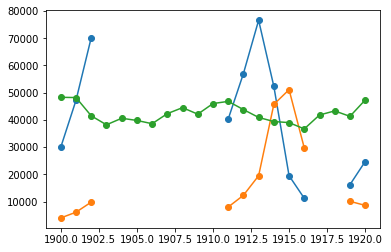

In [124]:
import matplotlib.pyplot as plt
plt.plot(year, populations, 'o-') 
plt.show()

### 2.2.4.3 recarray：仅仅方便

In [125]:
arr = np.array([('a', 1), ('b', 2)], dtype=[('x', 'S1'), ('y', int)])
arr2 = arr.view(np.recarray)
arr2.x

array([b'a', b'b'], 
      dtype='|S1')

In [10]:
arr2.y

array([1, 2])

### 2.2.4.4 矩阵：方便？

- 通常是2-D
- \* 是矩阵的积，不是元素级的积

In [126]:
np.matrix([[1, 0], [0, 1]]) * np.matrix([[1, 2], [3, 4]])

matrix([[1, 2],
        [3, 4]])

## 2.2.5 总结

- ndarray的剖析：data、dtype, 步长
- 通用函数：元素级操作，如何常见一个新的通用函数
- Ndarray子类
- 整合其他工具的多种buffer接口
- 最近的补充：PEP 3118，广义ufuncs

## 2.2.6 为Numpy/Scipy做贡献

看一下这篇教程：http://www.euroscipy.org/talk/882

### 2.2.6.1 为什么

- “这有个bug?”
- “我不理解这个要做什么？”
- “我有这个神器的代码。你要吗？”
- “我需要帮助！我应该怎么办？”

### 2.2.6.2 报告bugs

- Bug跟踪（推荐这种方式）
    - http://projects.scipy.org/numpy
    - http://projects.scipy.org/scipy
    - 点击“注册”链接获得一个帐号

- 邮件列表 ( scipy.org/Mailing_Lists )
    - 如果你不确定
    - 在一周左右还没有任何回复？去开一个bug ticket吧。
    
#### 2.2.6.2.1 好的bug报告

---

Title: numpy.random.permutations fails for non-integer arguments

I'm trying to generate random permutations, using numpy.random.permutations

When calling numpy.random.permutation with non-integer arguments it fails with a cryptic error message::

    >>> np.random.permutation(12)
    array([ 6, 11,  4, 10,  2,  8,  1,  7,  9,  3,  0,  5])
    >>> np.random.permutation(12.)
    Traceback (most recent call last):
      File "<stdin>", line 1, in <module>
      File "mtrand.pyx", line 3311, in mtrand.RandomState.permutation
      File "mtrand.pyx", line 3254, in mtrand.RandomState.shuffle
    TypeError: len() of unsized object

This also happens with long arguments, and so np.random.permutation(X.shape[0]) where X is an array fails on 64 bit windows (where shape is a tuple of longs).

It would be great if it could cast to integer or at least raise a proper error for non-integer types.

I'm using Numpy 1.4.1, built from the official tarball, on Windows 64 with Visual studio 2008, on Python.org 64-bit Python.

---

0. 你要做什么？
1. **重现bug的小代码段**（如果可能的话）
    - 实际上发生了什么
    - 期望发生什么
2. 平台（Windows / Linux / OSX, 32/64 bits, x86/PPC, ...）
3. Numpy/Scipy的版本

In [128]:
print(np.__version__)

1.12.1


**检查下面的文件是你所期望的**

In [ ]:
print(np.__file__)

以免你想要旧/损坏的Numpy安装在哪里

如果不确定，试着删除现有的Numpy安装文件，并且重新安装...

### 2.2.6.3 为文档做贡献

1. 文档编辑器
    - http://docs.scipy.org/numpy
    - 注册
        - 注册一个帐号
        - 订阅scipy-dev邮件列表（仅限订阅者）
        - 邮件列表有问题：你可以发邮件
            - 但是：**你可以关闭邮件送达**
            - 在http://mail.scipy.org/mailman/listinfo/scipy-dev 底部“改变你的订阅选项”
       - 给@`scipy-dev`邮件列表发一封邮件；要求激活：

    ---
    > To: scipy-dev@scipy.org

    > Hi,

    > I'd like to edit Numpy/Scipy docstrings. My account is XXXXX

    > Cheers,
    
    > N. N.
    
    ---

        - 检查一下风格指南：
            - http://docs.scipy.org/numpy/
        - 不要被吓住；要修补一个小事情，就修补它
    - 编辑    
2. 编辑源码发送补丁（和bug一样）
3. 向邮件列表抱怨


### 2.2.6.4 贡献功能

0. 在邮件列表上询问，如果不确定应该它应该在哪里
1. 写一个补丁，在bug跟踪器上添加一个增强的ticket
2. 或者，创建一个实现了这个功能的Git分支 + 添加增强ticket。
    - 特别是对于大的/扩散性的功能添加
    - http://projects.scipy.org/numpy/wiki/GitMirror
    - http://www.spheredev.org/wiki/Git_for_the_lazy

In [ ]:
# 克隆numpy仓库
git clone --origin svn http://projects.scipy.org/git/numpy.git numpy
cd numpy

# 创建功能分支
git checkout -b name-of-my-feature-branch  svn/trunk

<edit stuff>

git commit -a

- 在http://github.com （或者其他地方）创建一个帐号
- @ Github创建一个新仓库
- 将你的工作推送到github

```shell
git remote add github git@github:YOURUSERNAME/YOURREPOSITORYNAME.git
git push github name-of-my-feature-branch
```

### 2.2.6.5 如何帮助，总体而言

- 永远欢迎修补bug！
    - 什么让你最恼怒
    - 浏览一下跟踪器
- 文档工作
    - API文档：改善文档字符串
        - 很好的了解了一些Scipy模块
    - 用户指南
        - 最终需要完成
        - 想要想一下？看一下目录
            http://scipy.org/Developer_Zone/UG_Toc
- 在沟通渠道上询问：
    - `numpy-discussion` 列表
    - `scipy-dev` 列表